In [1]:
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using Plots, GraphPlot, Colors  # For plottig

OPT = () -> ECOS.Optimizer(verbose=false)

#1 (generic function with 1 method)

# Generate some random data

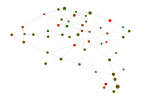

In [2]:
Random.seed!(2)
n = 50

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate carbon costs
c = rand(Exponential(2), n)

# Generate demands
d = rand(Bernoulli(0.8), n) .* rand(Gamma(3.0, 3.0), n)

# Generate generation and flow capacities
gmax = rand(Gamma(4.0, 3.0), n) + (1/2)*d  # This is just to make the problem easier
pmax = rand(Gamma(2.0, 2.0), m)

# Plot network
nodesize = maximum(d) .+ d
nodefillc = weighted_color_mean.((c/maximum(c)).^0.5, colorant"red", colorant"green")
edgelinewidth = (pmax / maximum(pmax)).^0.5

Random.seed!(0)  # I put a seed here so the spring layout doesn't change
plt = gplot(G, nodesize=nodesize, nodefillc=nodefillc, edgelinewidth=edgelinewidth)

# Solve the carbon management problem

In [11]:
g = Variable(n)
p = Variable(m)

objective = c'g
constraints = [
    abs(p) <= pmax,
    0 <= g, 
    g <= gmax,
    g - d == A*p
]

problem = minimize(objective, constraints)
solve!(problem, OPT, verbose=true)

# Plot results

`GraphPlot` is only for making simple plots. To do more advanced things (like the plot in the carbon accounting paper), we'll need to draw the graph manually.

For now, I'm going to make some simple diagnostic plots.

## Plot demand, generation, and LMPs

Here, the LMPs are carbon LMPs.

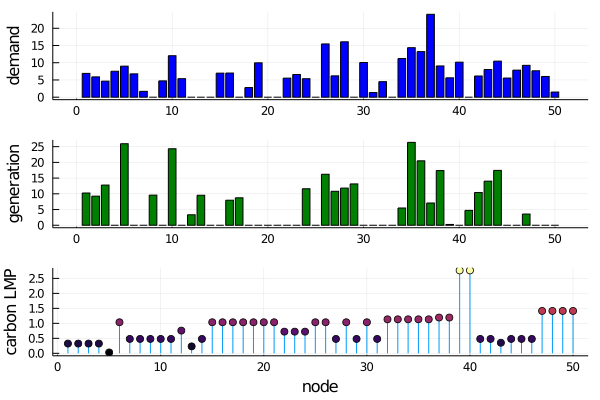

In [12]:
λ = constraints[4].dual[:, 1]  # <-- LMPs

# Fancy colors
gradient = cgrad(:inferno)
lmp_colors = [get(gradient, λi/maximum(λ)) for λi in λ]


plt1 = bar(d, label=nothing, c=:blue, ylabel="demand")
plt2 = bar(evaluate(g), label=nothing, c=:green, ylabel="generation")
plt3 = sticks(λ, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, λ, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Plot carbon LMPs

Brighter is more carbon intensive. At the bright nodes (orange and yellow), increasing / decreasing demand has the greatest effect on total emissions.

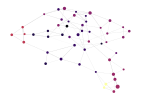

In [13]:
Random.seed!(0)  # <-- For the node layout consistency
plt = gplot(G, nodesize=nodesize, nodefillc=lmp_colors, edgelinewidth=edgelinewidth)

# Implicit diff

In [19]:
Random.seed!(4)

f = 1 ./ c  #1 .+ rand(Exponential(3), n)  # generate monetary costs

# Solve cost minimization problem
g = Variable(n)
p = Variable(m)

objective = f'g + 1e-4 *(sumsquares(p))
constraints = [
    -p <= pmax,
    p <= pmax,
    -g <= 0, 
    g <= gmax,
    A*p - g + d == 0
]

problem = minimize(objective, constraints)
solve!(problem, OPT, verbose=true)

function flatten_variables(problem::Problem)
    x = [evaluate(g); evaluate(p)]
    λ = vcat([c.dual for c in constraints]...)
    return [x; λ][:, 1]
end

function unflatten_variables(x)
    i = 0
    
    g = x[i+1:i+n]
    i += n
    
    p = x[i+1:i+m]
    i += m
    
    λpl = x[i+1:i+m]
    i += m
    λpu = x[i+1:i+m]
    i += m
    
    λgl = x[i+1:i+n]
    i += n
    λgu = x[i+1:i+n]
    i += n
    
    ν = x[i+1:i+n]
    
    return g, p, λpl, λpu, λgl, λgu, ν
end


function kkt(x, θ)
    g, p, λpl, λpu, λgl, λgu, ν = unflatten_variables(x)
    d = θ
    return [
        f + ν - λgl + λgu #+ 2*1e-4 * g;
        -A'ν + λpu - λpl + 2*1e-4 * p;
        λpu .* (p - pmax);
        -λpl .* (-p - pmax);
        -λgl .* g;
        λgu .* (g - gmax);
        A*p - g + d;
    ]
end

x = flatten_variables(problem)
@show norm(kkt(x, d))

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/degleris/.julia/packages/Convex/nF0tU/src/solution.jl:253


norm(kkt(x, d)) = 1.550858639170505e-5


1.550858639170505e-5

In [15]:
using Zygote, LinearAlgebra

In [20]:
# Get partial Jacobians of KKT operator
_, ∂K_xT = Zygote.forward_jacobian(x -> kkt(x, d), x)
_, ∂K_θT = Zygote.forward_jacobian(θ -> kkt(x, θ), d)
@show minimum(svdvals(∂K_xT))

# Compute dC/dg (carbon derivative wrt generation)
∇C = zeros(size(x))
∇C[1:n] .= c

# First solve least squares problem
# v = argmin_v || ∂K_x' * v - ∇C ||_2^2
# Except we only care about the first component (generation)...
# So we solve
# v = argmin_v || ∂K_x[1:n, :]' - c||_2^2
# M = ∂K_xT[1:n, :]
v = inv(∂K_xT) * ∇C  #M \ c
#@show norm(M*v - c)

# Now compute ∇C(g*(θ)) = -∂K_θ'v
∇C_θ = -∂K_θT * v;

minimum(svdvals(∂K_xT)) = 1.6752275901095805e-5


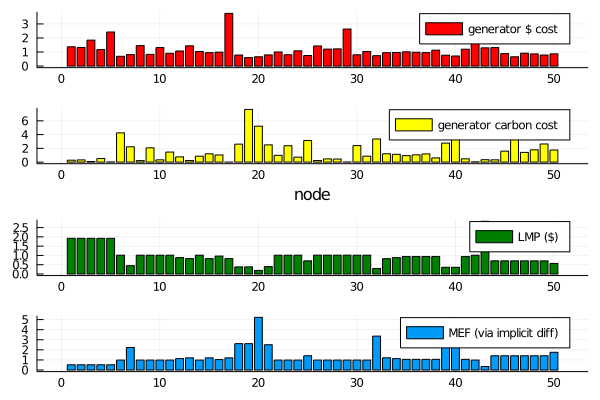

In [23]:
ν = -problem.constraints[5].dual[:, 1]
plt1 = bar(∇C_θ, label="MEF (via implicit diff)")
plt2 = bar(ν, label="LMP (\$)", color=:green)
plt25 = bar(f .^ (1/4), label="generator \$ cost", color=:red)
plt3 = bar(c, label="generator carbon cost", color=:yellow, xlabel="node")

plot(plt25, plt3, plt2, plt1, layout=(4, 1))

minimum(∂K_xT) = -29.907829758693286
maximum(∂K_xT) = 15.994136972230413


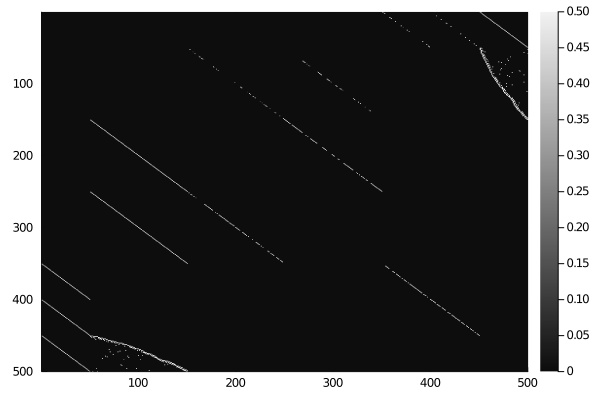

In [10]:
# Analyze Jacobian
@show minimum(∂K_xT)
@show maximum(∂K_xT)
heatmap(abs.(∂K_xT), yflip=true, c=:grays, clim=(0, 0.5))